In [1]:
import tensorflow as tf
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create the dataset
data_dir = Path('./dataset/mudkip/')

img_height = 200
img_width = 200

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed = 258, # mudkips pokedex number
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    shuffle=True
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed = 258, # mudkips pokedex number
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    shuffle=True
)

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 170 files belonging to 2 classes.
Using 136 files for training.
Found 170 files belonging to 2 classes.
Using 34 files for validation.


In [3]:
# Create model
# TODO: mess around and learn more about the layers
# The number of classes may differ depending on the hunt and how it is compiled
# It will either be 2 (target_normal, target_shiny) or 4 (target_normal, target_shiny, not_target_normal, not_target_shiny) 
number_of_classes = len(class_names)

#data_augmentation = tf.keras.models.Sequential()
#data_augmentation.add(tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)))
#data_augmentation.add(tf.keras.layers.RandomRotation(0.1))
#data_augmentation.add(tf.keras.layers.RandomZoom(0.1))

model = tf.keras.models.Sequential()
#model.add(data_augmentation)
model.add(tf.keras.layers.Rescaling(1/.255, input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(number_of_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       7

Epoch 1/10
5/5 [==============================] - 8s 1s/step - loss: 2926.4082 - accuracy: 0.4706 - val_loss: 159.4771 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 5s 998ms/step - loss: 71.7902 - accuracy: 0.5515 - val_loss: 2.3623 - val_accuracy: 0.6176
Epoch 3/10
5/5 [==============================] - 5s 983ms/step - loss: 6.5112 - accuracy: 0.5368 - val_loss: 1.3789 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 5s 981ms/step - loss: 0.9406 - accuracy: 0.5882 - val_loss: 0.7006 - val_accuracy: 0.5882
Epoch 5/10
5/5 [==============================] - 5s 998ms/step - loss: 0.5095 - accuracy: 0.7426 - val_loss: 0.7121 - val_accuracy: 0.6471
Epoch 6/10
5/5 [==============================] - 5s 997ms/step - loss: 0.4555 - accuracy: 0.7647 - val_loss: 0.5418 - val_accuracy: 0.7353
Epoch 7/10
5/5 [==============================] - 5s 978ms/step - loss: 0.4371 - accuracy: 0.7868 - val_loss: 0.5115 - val_accuracy: 0.7353
Epoch 8/10
5/5 [=

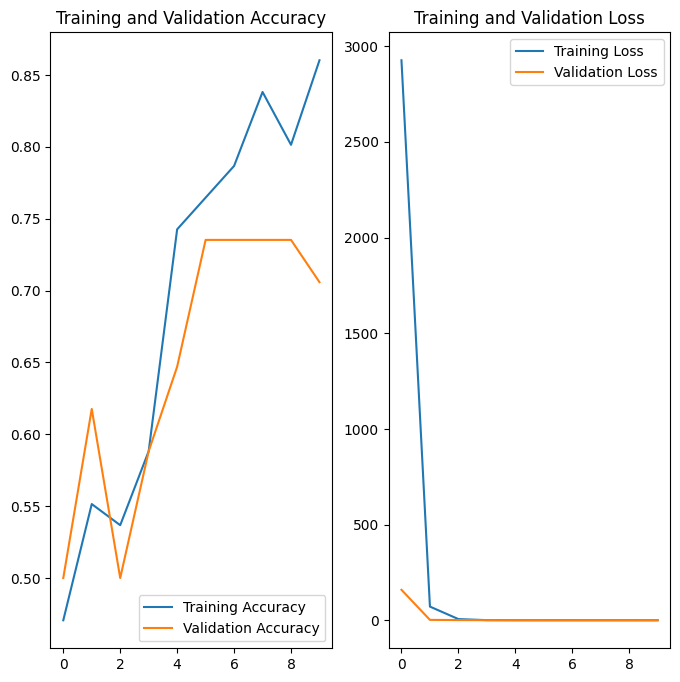

In [4]:
# Train model
epochs = 10
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs)

# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Test the model with a single image
test_path = Path('./test_imgs/mudkip/40.png')

img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width), keep_aspect_ratio=True)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely is {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score)))
img

In [6]:
# Test the model in a batch
# TODO: TEST ON LIVE STREAM ARCHIVES
test_path = Path('./test_imgs/mudkip/')
actual = ['target_normal', 'target_normal', 'target_normal', 'target_normal', 'target_normal',
          'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny',
          'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny',
          'target_normal', 'target_normal', 'target_normal', 'target_normal', 'target_normal',
          'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny',
          'target_normal', 'target_normal', 'target_normal', 'target_normal', 'target_normal',
          'target_normal', 'target_normal', 'target_normal', 'target_normal', 'target_normal',
          'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny']
predicts = []

for file in test_path.iterdir():
    img = tf.keras.utils.load_img(file, target_size=(img_height, img_width), keep_aspect_ratio=True)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    predicts.append(class_names[np.argmax(score)])
    print("This image most likely is {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score)))

overall_score = 0
normal_score = 0
shiny_score = 0
for i in range(40):
    if actual[i] == predicts[i]:
        overall_score += 1
        if actual[i] == 'target_normal':
            normal_score += 1
        elif actual[i] == 'target_shiny':
            shiny_score += 1

overall_percent = (overall_score / len(actual)) * 100
normal_percent = (normal_score / (len(actual) / 2)) * 100
shiny_percent = (shiny_score / (len(actual) / 2)) * 100

print(f"Overall Score: {overall_percent}% ({overall_score}/{len(actual)})")
print(f"Normal Score: {normal_percent}% ({normal_score}/{len(actual) / 2})")
print(f"Shiny Score: {shiny_percent}% ({shiny_score}/{len(actual) / 2})")

1/1 [==============================] - 0s 32ms/step
This image most likely is target_shiny with a 78.74 percent confidence
1/1 [==============================] - 0s 32ms/step
This image most likely is target_normal with a 73.28 percent confidence
1/1 [==============================] - 0s 56ms/step
This image most likely is target_normal with a 73.06 percent confidence
1/1 [==============================] - 0s 38ms/step
This image most likely is target_normal with a 63.84 percent confidence
1/1 [==============================] - 0s 41ms/step
This image most likely is target_shiny with a 61.96 percent confidence
1/1 [==============================] - 0s 52ms/step
This image most likely is target_shiny with a 58.88 percent confidence
1/1 [==============================] - 0s 41ms/step
This image most likely is target_shiny with a 51.77 percent confidence
1/1 [==============================] - 0s 35ms/step
This image most likely is target_normal with a 73.55 percent confidence
1/1 [=======

In [ ]:
# TODO: Save the model